# Ames, Iowa : Predicting Sales Prices - Penalized Linear Regression Modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,\
MinMaxScaler, MaxAbsScaler, FunctionTransformer, PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from LR_helper import cat_column_combine_vars, num_new_features,\
label_encode_features, model_results, cat_new_features, std_num_cols
from clean_helper import dtype_update
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

## Loading cleaned training and testing datasets:-

In [2]:
train_df = pd.read_csv("clean_train.csv",index_col=0)
test_df = pd.read_csv("clean_test.csv",index_col=0)
print(train_df.shape)
print(test_df.shape)

(1453, 80)
(1457, 79)


- Creating copies to apply diffrent transformations and engineering techniques:

In [3]:
train_df_cpy = train_df.copy()
test_df_cpy = test_df.copy()
print(train_df_cpy.shape)
print(test_df_cpy.shape)

(1453, 80)
(1457, 79)


## Creating new numerical variables, combining variables and creating new categorical variables:-

In [4]:
# Creating new numerical variable features:-
num_new_features(train_df)
num_new_features(test_df)
num_new_features(train_df_cpy)
num_new_features(test_df_cpy)

# Combining categories in some categorical features:-
cat_column_combine_vars(train_df)
cat_column_combine_vars(test_df)
cat_column_combine_vars(train_df_cpy)
cat_column_combine_vars(test_df_cpy)

# Creating new categorical variable features:-
cat_new_features(train_df)
cat_new_features(test_df)
cat_new_features(train_df_cpy)
cat_new_features(test_df_cpy)

In [5]:
print(train_df.shape)
print(test_df.shape)

(1453, 88)
(1457, 87)


In [6]:
print(train_df_cpy.shape)
print(test_df_cpy.shape)

(1453, 88)
(1457, 87)


## In-depth EDA to research relationship with Sales Price

In [7]:
train_df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Finished Basement relation to Sale Prices

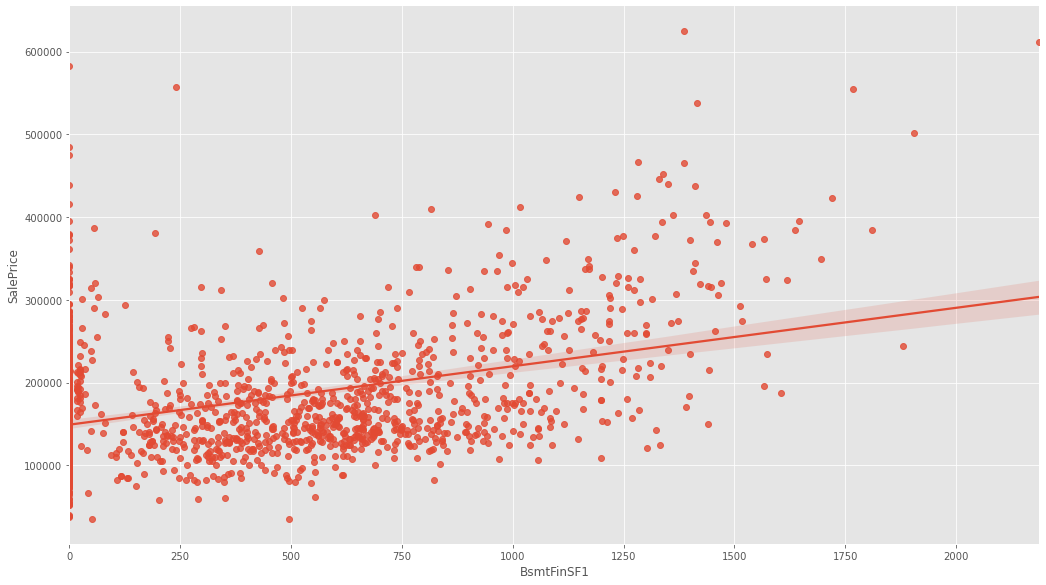

In [8]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

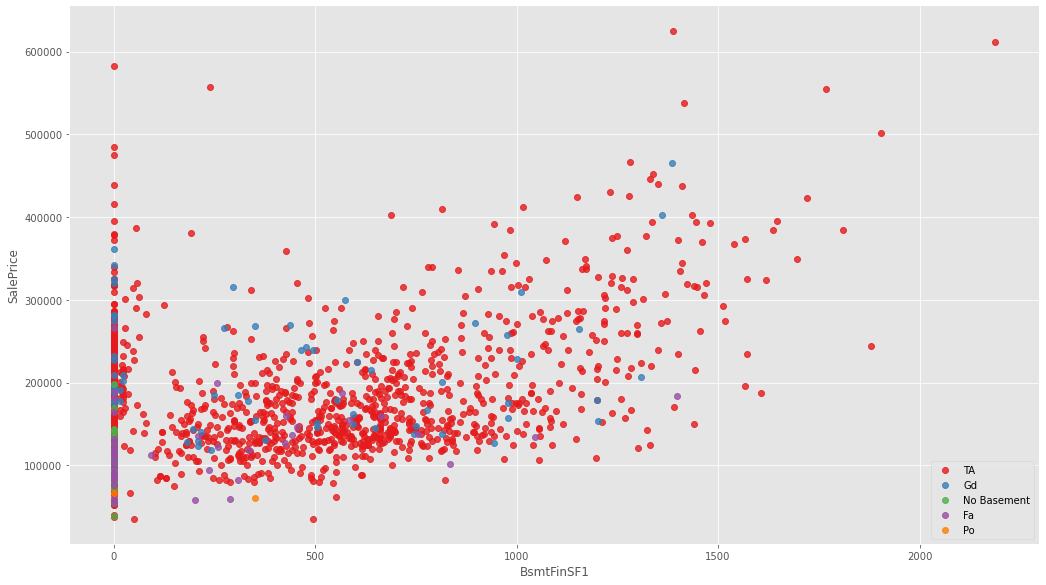

In [9]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BsmtCond', legend=False)
plt.legend(loc='lower right')

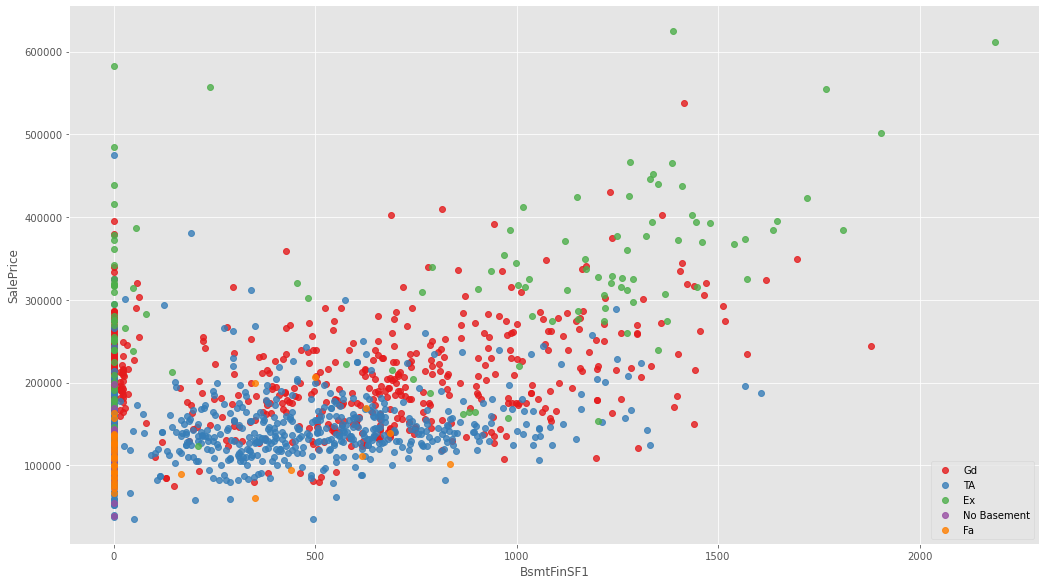

In [10]:
sns.lmplot("BsmtFinSF1", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BsmtQual', legend=False)
plt.legend(loc='lower right')

### Above ground living area

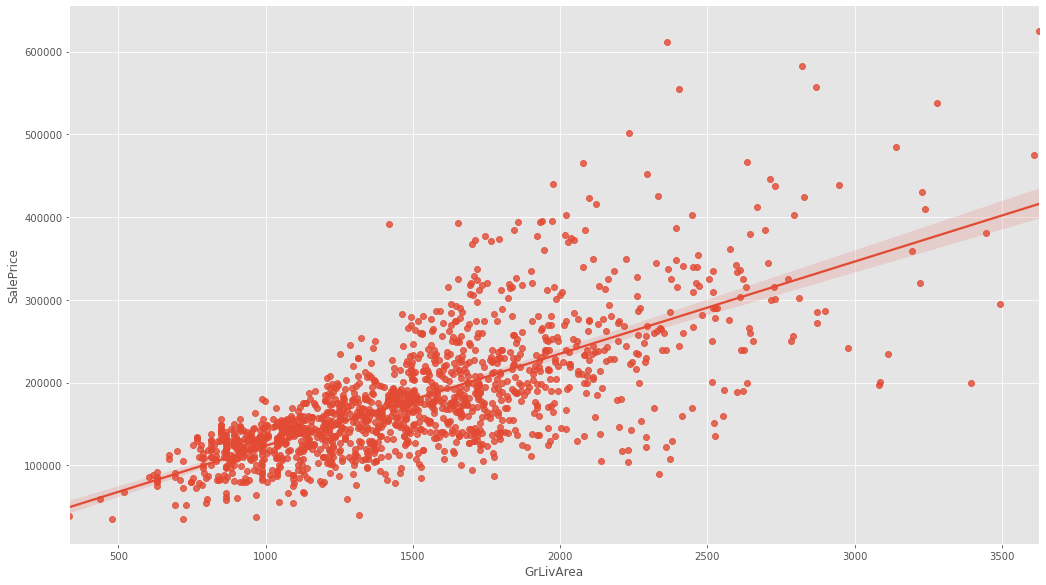

In [11]:
sns.lmplot("GrLivArea", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

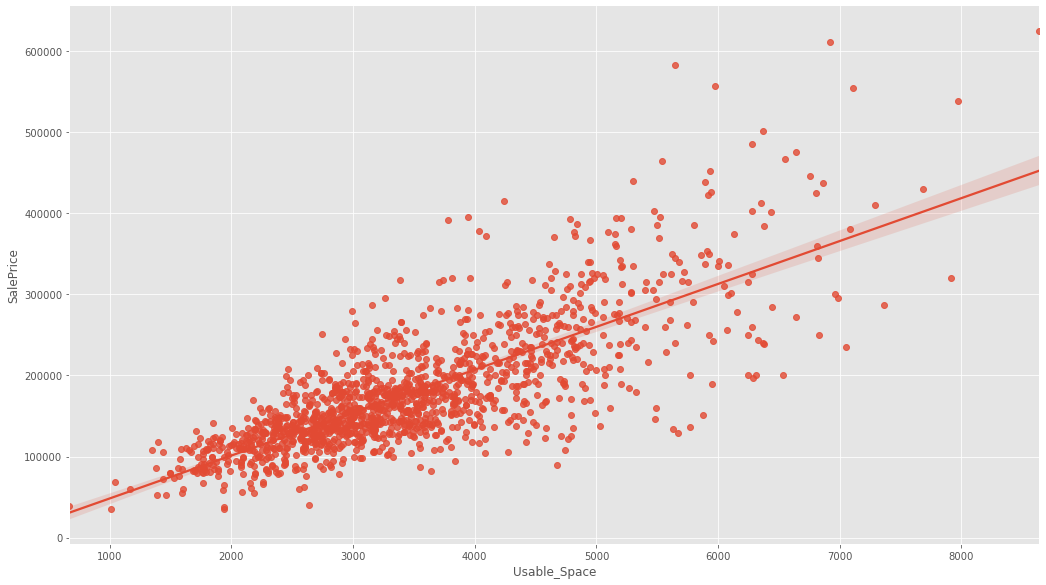

In [12]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set2")

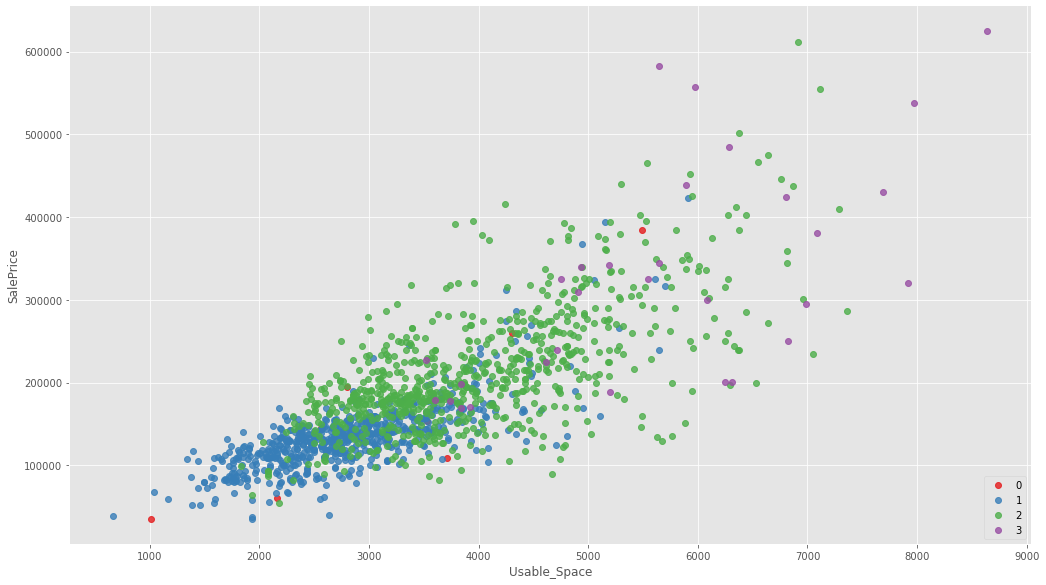

In [13]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='FullBath', legend=False)
plt.legend(loc='lower right')

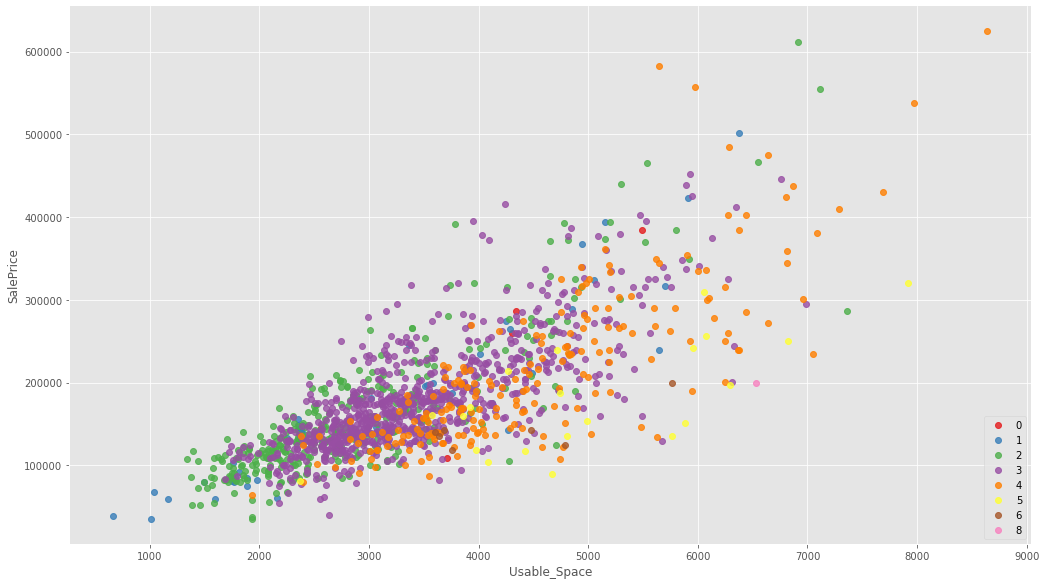

In [14]:
sns.lmplot("Usable_Space", "SalePrice", train_df, height=8, aspect=1.8, palette="Set1",\
           fit_reg=False, hue='BedroomAbvGr', legend=False)
plt.legend(loc='lower right')

- Years since remodeled and remodeled or not

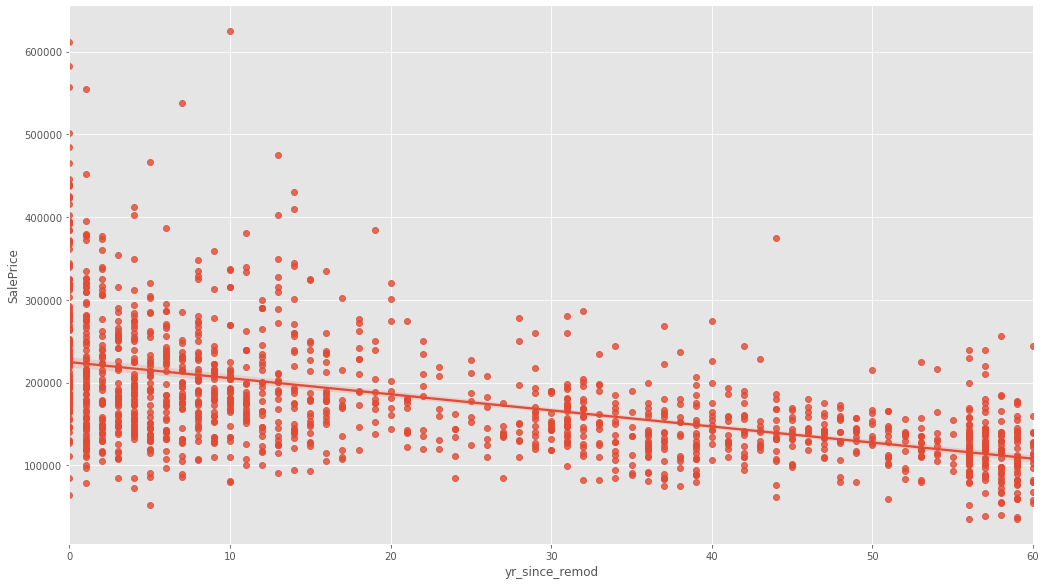

In [15]:
sns.lmplot("yr_since_remod", "SalePrice", train_df, height=8, aspect=1.8, palette="Pastel1")

Text(0.5, 1.0, 'House Price vs Years Since Remodeled')

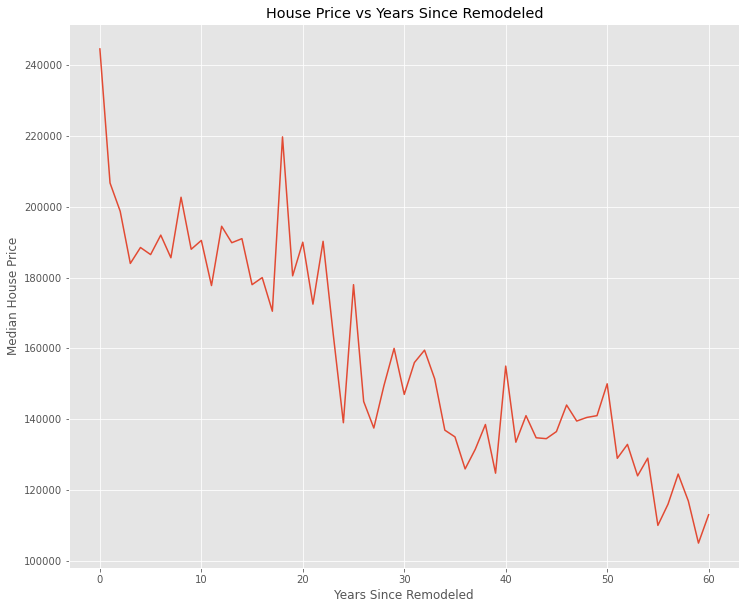

In [16]:
plt.figure(figsize = (12,10))
train_df.groupby('yr_since_remod')['SalePrice'].median().plot()
plt.xlabel('Years Since Remodeled')
plt.ylabel('Median House Price')
plt.title("House Price vs Years Since Remodeled")

<AxesSubplot:xlabel='remod_y_n', ylabel='SalePrice'>

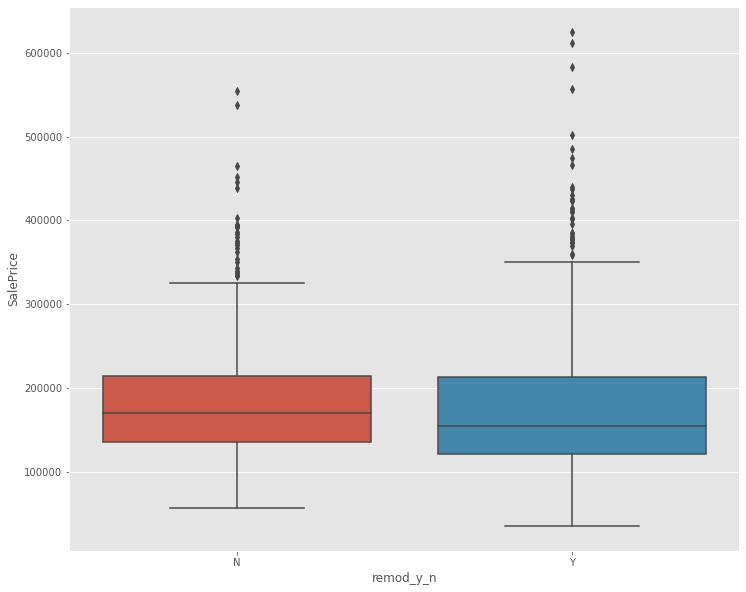

In [17]:
plt.figure(figsize = (12,10))
my_order = train_df.groupby('remod_y_n')['SalePrice']\
           .median().sort_values(ascending=False).index
sns.boxplot(data=train_df, x='remod_y_n', y='SalePrice', order=my_order)

## Label encoding categorical features (all dataframes):

In [18]:
#Label encoding via helper functions:-

label_encode_features(train_df)
label_encode_features(test_df)
label_encode_features(train_df_cpy)
label_encode_features(test_df_cpy)

## OneHot encoding categorical features (all dataframes):

In [19]:
col_list = ['Street', 'Alley', 'LandContour','RoofStyle','Exterior1st','MSZoning',\
            'Utilities', 'LotConfig','Neighborhood', 'Condition1', 'Condition2',\
            'BldgType', 'YearBuilt', 'YearRemodAdd', 'RoofMatl', 'Foundation','MasVnrType',\
            'CentralAir','Heating', 'Electrical', 'Functional','Exterior2nd','GarageType',\
            'GarageFinish', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'YrSold',\
            'SaleType', 'SaleCondition','remod_y_n', 'HouseStyle', 'MSSubClass']

train_df = pd.get_dummies(data=train_df, columns=col_list, drop_first=True)
test_df = pd.get_dummies(data=test_df, columns=col_list, drop_first=True)

train_df_cpy = pd.get_dummies(data=train_df_cpy, columns=col_list, drop_first=True)
test_df_cpy = pd.get_dummies(data=test_df_cpy, columns=col_list, drop_first=True)

## Standardizing numerical columns:

- Only for the copies of test and train dfs

In [20]:
std_num_cols(train_df_cpy)
std_num_cols(test_df_cpy)